# Лабораторная работа №2
## Выполнили: Залесская Галина, Елькина Варвара

In [6]:
import numpy as np
import pandas as pd
from random import choice
from sklearn import preprocessing

В нашем расположении имеются короткий алфавит из 4 символов и длинный, состоящий из всех английских букв алфавита

In [9]:
alphabet_sh = ['a','b','c','d']
alphabet= [chr(i) for i in range(97,123)]

# Наивный алгоритм

Наивный алгоритм считается самым простым алгоримтом для поиска подстроки в строке. В качестве атомарной операции исполбзуется сравнение двух символов. 

In [262]:
def Naive(text, pattern, alphabet):
    n = len(text)
    m = len(pattern)
    incl=[]
    operations=0
    for s in range(n-m+1):
        i=0
        while (i < m):
            operations+=1
            if (pattern[i]!=text[s+i]):
                break
            i+=1
        if (i==m):
            incl.append(s)   
    return (incl,operations)

# Rabin-Karp algorithm

В качестве атомарной операции были использованы сравнение символов, создание нового хэша и сравнение хэшей. Для перевода листа из символов в лист из чисел (маленьких чисел, не превосходящих мощность используемого алфавита) была использована функция препроцессинга LabelEncoder. Однако сложность ее работы не суммировалась со сложностью алгоритма, чтобы не создать искажение при сравнении алгоритма с остальными.

In [263]:
def RK(text, pattern,alphabet):
    n = len(text)
    m = len(pattern)
    text = list(text)
    pattern = list(pattern)
    incl=[]
    operations=0
    d=len(alphabet)
    p=0
    t=0
    q=1013
    
    le = preprocessing.LabelEncoder()
    le.fit(alphabet)
    text = le.transform(text)
    pattern = le.transform(pattern)
    
    for i in range(m):
        p = (d*p + pattern[i]) % q
        t = (d*t + text[i]) % q
    
    for i in range(n-m+1):
        operations+=1 #hash comparison
        if (p == t):
            j=0
            while (j < m):
                operations+=1 #char comparison
                if (pattern[j]!=text[i+j]):
                    break
                j+=1
            if (j==m):
                incl.append(i)
        operations+=1 #new hash
        t = ((t - text[i] * (d**(m-1)))*d + text[(i+m)%n]) % q
            
    return incl,operations 

# Boyer-Moore-Horspool algoritm

Для алгоритма BMH суммируются все операции в препроцессинге, а так же каждый случай сравнения символов. 

In [265]:
def BMH (text, pattern, alphabet):    
    n = len(text)
    m = len(pattern)
    text = list(text)
    pattern = list(pattern)
    incl=[]
    d=len(alphabet)
    operations=0
    table = [m for i in range (d)]
    
    le = preprocessing.LabelEncoder()
    le.fit(alphabet)
    pattern = le.transform(pattern)
    text = le.transform(text)
   
    for i in range(m-1):
        operations+=1 #preprocessing
        table[pattern[i]] = m-1-i #количество безопасно пропускаемых символов

    skip = 0
    while (n - skip >= m):
        i = m - 1 
        while (text[skip+i] == pattern[i]):
            operations+=1 # char comparison
            if (i==0):               
                incl.append(skip)
                break;
            i-=1
        skip = skip + table[text[skip+m-1]]
    return incl, operations

# Knuth-Morris-Pratt algorithm

Сложность алгоритма суммируется из двойного прохождения по тексту во время формирования массива эвристики префикса. А так же сравнения символов во время работы основного алгоритма.

In [266]:
def KMP(text, pattern, alphabet):
    n = len(text)
    m = len(pattern)
    large_text = pattern +'$' + text
    
    incl=[]
    d=len(alphabet)
    operations=0
    table = [m for i in range (d)]
    
#prefix fun    
    prefix = [0]*(m+n+1)
    k = 0
    for i in range(1,m+n+1):
        k = prefix[i-1]
        operations+=1
        while ((k>0) and (large_text[k]!=large_text[i])):
            k=prefix[k-1]
        operations+=1
        if (large_text[k]==large_text[i]):
            k+=1
        prefix[i]=k

    for i in range(m+1, m+n+1):
        if (prefix[i] == m):
            operations+=1
            incl.append(i-2*m)
    return (incl, operations)

# Блок для сравнения алгоритмов

In [258]:
def text_generator(alpha, n):   #текст длины n
    return (''.join([choice(alpha) for x in range(n)]))

In [81]:
def textset_generator(alpha, n): #датасет из тысячи текстов длины п
    set = []
    for i in range (1000):
        set.append(text_generator(alpha, n))
    return set

In [82]:
def info_computing(algorythm, set, pattern, alphabet): 
    #необходимая информация о количестве операций для каждого алгоритма при работе с текстами из set
    aver=max=0
    n = np.shape(set)[0]
    min = n**2
    for text in set:
        value = algorythm(text, pattern, alphabet)[1]
        aver+=value
        if (value>max):
            max=value
        if (value<min):
            min=value
    aver = aver / n
    return max, aver, min
        

In [93]:
import matplotlib.pyplot as plt
import pandas as pd

In [272]:
#паттерн, который мы ищем в текстах. Для удобства один для всех
pat = 'abc'

In [267]:
#красивое и наглядное представление таблицой
def table_information(alphabet):
    table = pd.DataFrame()
    algorythms = [Naive, RK, BMH, KMP]
    lenght = [10,100,1000,10000]
    for alg in algorythms:
        for l in lenght:
            line = np.asarray(info_computing(alg, textset_generator(alphabet,l), pat, alphabet))
            line = pd.DataFrame(data = line, index=['max','average', 'min'], columns = [alg.__name__+' : '+str(l)])
            table=pd.concat([table,line], axis=1)
    return table.T

In [268]:
# работа алгоритмов на текстах длины 10,100,1000,10000 на маленьком алфавите из 4 символов
result_sh= table_information(alphabet_sh)
result_sh

,max,average,min
Naive : 10,16.0,10.406,8.0
Naive : 100,148.0,128.489,110.0
Naive : 1000,1363.0,1309.319,1259.0
Naive : 10000,13307.0,13123.002,12950.0
RK : 10,22.0,16.414,16.0
RK : 100,214.0,200.440,196.0
RK : 1000,2086.0,2042.776,2014.0
RK : 10000,20569.0,20465.575,20356.0
BMH : 10,9.0,3.503,2.0
BMH : 100,36.0,19.165,7.0


In [269]:
# работа алгоритмов на текстах длины 10,100,1000,10000 на обычном английском алфавите
result = table_information(alphabet)
result

,max,average,min
Naive : 10,11.0,8.315,8.0
Naive : 100,110.0,101.872,98.0
Naive : 1000,1057.0,1037.836,1020.0
Naive : 10000,10476.0,10397.450,10327.0
RK : 10,17.0,16.006,16.0
RK : 100,199.0,196.111,196.0
RK : 1000,2003.0,1997.151,1996.0
RK : 10000,20025.0,20007.412,19997.0
BMH : 10,4.0,2.146,2.0
BMH : 100,8.0,3.427,2.0


In [275]:
# давайте нарисуем количество операций для каждого алгоритма на тестах разной длины при маленьком и большом алфавитах
def graph_info(result):
    algorythms = [Naive, RK, BMH, KMP]
    lenght = [10,100,1000,10000]
    diap = np.shape(lenght)[0] 
    for i in range(0, np.shape(algorythms)[0]):
        y = result_sh['average'].values[i*diap:(i+1)*diap] #маленький алфавит
        plt.plot(lenght, y)
        
        y = result['average'].values[i*diap:(i+1)*diap] #обычный алфавит
        plt.plot(lenght, y)
        
        plt.yticks(y)
        plt.title(algorythms[i].__name__) #название представленного алгоритма
        plt.xscale('log') 
        plt.show()
        
#блок для сравнения работы всех 4 алгоритмов на маленьком алфавите       
    for i in range(0, np.shape(algorythms)[0]):
        y = result_sh['average'].values[i*diap:(i+1)*diap]
        plt.plot(lenght, y)
    
    plt.legend([algorythms[i].__name__ for i in range(0,4)])
    plt.yticks(y)
    plt.title("Comparison of algorythms")
    plt.xscale('log') 
    plt.show()

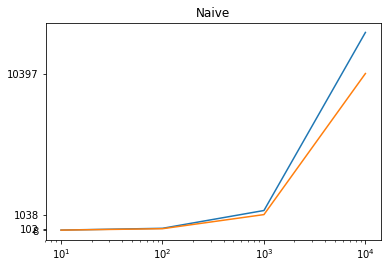

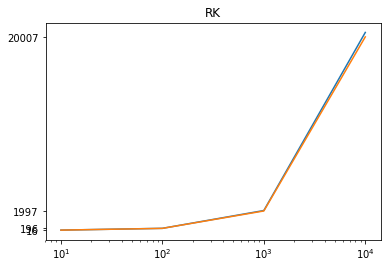

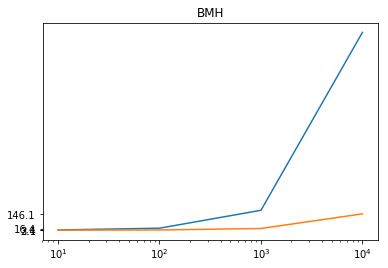

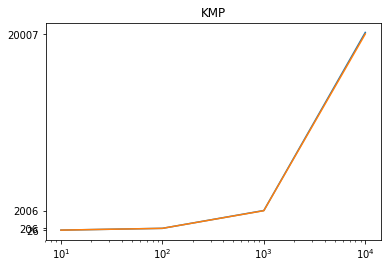

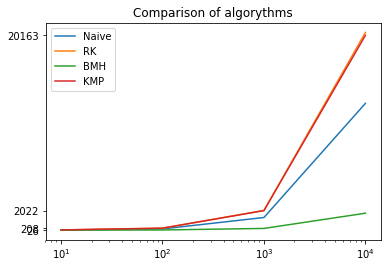

In [276]:
graph_info(result)

Как можно заметить, не у всех алгоритмов увеличение длины алфавита ведет к увеличению числа операций. У RK, BMH эти значения почти совпадает, что связано со спецификой алгоритма, а так же с тем, что искомый паттерн не изменяется при изменении алфавита.

Диаграмма сравнения алгоритмов обманчива, так как для каждого мы брали разные атомарные операции исходя из логики алгоритмов (где-то добавлялось хэширование, где-то препроцессинг - все это увеличивает число операций, но не говорит о низкой эффективности алгоритма). Так, например, судя по диаграмме, алгоритм BMH является самым эффективным, а второе место занимает наивный алгоритм. Если первое не вызывает вопросов, то второе довольно сомнительно.

Также из таблиц и графиков можно заметить, что число операций растет линейно, то есть увеличение длины текста на порядок (в 10 раз) так же увеличивает и число операций (в 10 раз).